## Image captioning с использованием Soft Attention:

<image src="https://kelvinxu.github.io/projects/diags/model_diag.png" width=700>


Данный jupiter notebook является прямым продолженеием image_captioning_no_attention.ipynb, поэтому настоятельно рекомендую сначала с ним ознакомиться

Загрузка библиотек

In [1]:
import random

import numpy as np
import torch
import torchvision as tv
import os
import re

import matplotlib.pyplot as plt

from PIL import Image
import skimage

from nltk.translate.bleu_score import corpus_bleu

from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms as T

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import skimage
%matplotlib inline  

Будем использовать MobileNet для выделения признаков с изображения. На этот раз не будем делать flattern и будем прямо брать выходной вектор после сверточной архитектуры размером  (7, 7, 576)

In [4]:
model = tv.models.mobilenet_v3_small(pretrained=True)

# Заморозка модели
for param in model.parameters():
    param.requires_grad = False

Опишем требуемые трансформации для датасета:

In [6]:
TRAIN_IMAGE_PATH = 'val2014'
ANNOTATION_PATH = 'annotations/captions_val2014.json'
transform = T.Compose([T.Resize(256), 
                       T.CenterCrop(224), 
                       T.ToTensor(), 
                       T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

Зададим датасет:


In [8]:
dataset = tv.datasets.CocoCaptions(TRAIN_IMAGE_PATH,ANNOTATION_PATH,transform)
print('Количество изображений в выборке: ', len(dataset))

Количество изображений в выборке:  40504


### Предобработка данных в датасете:

---
__Пояснение этой части кода смотри в предыдущем ноутбуке:__


In [9]:
def process_word_list(word_list):
    processed_list = []
    for word in word_list:
        # Приводим слово к нижнему регистру
        word = word.lower()
        # Удаляем все символы, кроме букв
        word = re.sub(r'[^a-zA-Z]', '', word)
        # Добавляем обработанное слово в список
        processed_list.append(word)
    return processed_list

In [17]:
# Загрузим словарь:
import pickle

with open('vocab.pkl', 'rb') as f:
    words = pickle.load(f)
word_to_id=dict(zip(words, range(len(words))))

Мы выбираем случайное предложение с описанием для каждой фотографии. Ограничиваем размер предложения в 20 слов, заставляя остальное паддингами. Добавляем в конце EOS

In [18]:
num_steps=20
def collate_sentences(list_data):
    images = []
    labels = []
    lens = []
    references = []
    for sample in list_data:
        image, label = sample
        label = random.choice(label)
        images.append(image)
        lens.append(len(label.split()) if len(label.split()) < num_steps else num_steps)

        # Получим кодировку слов как в словаре и в конце добавим код EOS
        EmbeddedSentence=[word_to_id[word] for word in process_word_list(label.split()) if word in word_to_id]+[word_to_id['EOS']]

        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        elif len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        else:
            b=EmbeddedSentence
        labels.append(torch.LongTensor(b))

        ref=[]
        for i in range(5):
            ref.append(process_word_list(label[i].split()))
        references.append(ref)

    lens, indices = torch.sort(torch.LongTensor(lens),descending=True)
    images = torch.index_select(torch.stack(images), 0, indices)
    labels = torch.index_select(torch.stack(labels), 0, indices)
        
    return images, labels, lens, references

---
__Начало новой части:__

Теперь мы будем обучать нашу LM. Мы будем использовать метод,  где на каждом временном шаге мы будем передавать RNN текущую подпись **И** вектор признаков изображения путем объединения каждый новый вход с вектором признаков.

Создание класса attention:

In [19]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)   # linear layer to transform encoder's output
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)   # linear layer to transform decoder's output
        self.full_attn = nn.Linear(attention_dim, 1)
    
    def forward(self, image_features, decoder_hidden): 
      # image_features = mobilenet.features(image) # [1,576,7,7]
      # decoder_hidden = LSTM_hidden nn.LSTM(input_dim, output_dim) # [B, 1, output_dim]
      # Q, K, V  V=image_features, Q=decoder_hidden, K=image_features 
        attn1 = self.encoder_attn(image_features)          # (batch_size, num_pixels, attention_dim)
        attn2 = self.decoder_attn(decoder_hidden)       # (batch_size, attention_dim)
        attn = self.full_attn(F.relu(attn1 + attn2.unsqueeze(1)))    # (batch_size, num_pixels, 1)

        # apply softmax to calculate weights for weighted encoding based on attention
        alpha = F.softmax(attn, dim=1)          # (batch_size, num_pixels, 1) num_pixels = 7 (width) * 7 (height)= 49
        attn_weighted_encoding = (image_features * alpha).sum(dim=1)  # (batch_size, encoder_dim)
        alpha = alpha.squeeze(2)  # (batch_size, num_pixels)
        return attn_weighted_encoding, alpha

Создание класса декодера:

In [20]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, dict_size, encoder_dim=2048, dropout=0.5):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = dict_size
        self.dropout = dropout
        
        
        self.embed = nn.Embedding(dict_size, embed_dim)                    # embedding layer
        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True) # decoding LSTMCell
        self.fc = nn.Linear(decoder_dim, dict_size)        # linear layer to find scores over vocabulary
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)     # attention network
        self.dropout = nn.Dropout(p=dropout)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)   # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)    # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)   # linear layer to create a sigmoid-activated gate
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)  # (batch_size, encoder_dim)
        h = self.init_h(mean_encoder_out)   # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)   # (batch_size, decoder_dim)
        return h, c
    
    def forward(self, encoder_out, encoded_captions, caption_lens):
        # encoder_out = mobilenet.features(image) # [1,7,7,576]
     
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1) *encoder_out.size(2)
        encoder_dim = encoder_out.size(-1)

        # flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)    # стало (1, 49, 576)
        num_pixels = encoder_out.size(1)
        
        # embedding
        embeddings = self.embed(encoded_captions)   # (batch_size, max_caption_length, embed_dim)

        # initialize lstm state
        h, c = self.init_hidden_state(encoder_out)      # (batch_size, decoder_dim)
        decode_lens = caption_lens.tolist() # (caption_lens - 1).tolist()

        # create tensors to hold word prediction scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lens), self.fc.weight.size(0)).to(device)
        alphas = torch.zeros(batch_size, max(decode_lens), num_pixels).to(device)

        # Тут будут генерироваться лова одни за другими так что это и отличает подход в прошлом ноутбуке.
        # Тогда генерация была [B, T, FI + FC]
        # Теперь станет [B, 1, FI + FC]
        for t in range(max(decode_lens)): # max(decode_lens) = 20 ->  максимальный размер описания

            batch_size_t = sum([l > t for l in decode_lens])

            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])

            gate = torch.sigmoid(self.f_beta(h[:batch_size_t]))     # sigmoid gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            h, c = self.lstm_cell(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1), #<word_t-1, image, h, c> -> word_t, c_t
                (h[:batch_size_t], c[:batch_size_t])
            )   # (batch_size_t, decoder_dim)


            # get the next word prediction
            preds = self.fc(self.dropout(h))    # (batch_size_t, vocab_size)

            # save the prediction and alpha for every time step
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
    
        return predictions, encoded_captions, decode_lens, alphas


In [21]:
#######################################################################################################
# Параметры
feature_dim = 576
lstm_dim = 1024
embed_dim = 1024
attention_dim = 2048
num_hidden = 256
num_steps=num_steps
dict_length=len(words)
batch_size = 100
#######################################################################################################

# Создание представления в виде батчей:
train_loader = torch.utils.data.DataLoader(dataset, batch_size, 
                                           shuffle=True, 
                                           collate_fn=collate_sentences,
                                           drop_last=True
                                          )

lr = 1e-3
loss_func = torch.nn.CrossEntropyLoss(reduction="sum")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
llm_model = DecoderWithAttention(attention_dim,embed_dim,lstm_dim,len(word_to_id),feature_dim)
llm_model.to(device)
optimizer = torch.optim.Adam(llm_model.parameters(), lr)

model.to(device)
EPOCHS = 10

def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

Обучение идентично подходу в прошлом ноутбуке:

In [22]:
model.eval()
llm_model.train()

alpha_c = 1.0

for ep in range(EPOCHS):
    print(f'Началось обучение {ep+1} эпохи')
    for idx, data in enumerate(train_loader):
        image, label, lens, references = data
        image, label = image.to(device), label.to(device)
        with torch.no_grad():
            feature = model.features(image) # [B,D,W,H] - (256,576,7,7)
        
        optimizer.zero_grad()

        # Задание начального символа BOS:
        start_symbol = label.new_full((label.size(0),1),word_to_id['BOS'])
        input_label = torch.cat([start_symbol, label],dim=-1)[:,:num_steps]
      
        out, encoded_captions, decode_lens, alphas = llm_model(feature.permute(0,2,3,1), input_label, lens)

        scores = pack_padded_sequence(
            out, lens, batch_first=True
        )
        targets = pack_padded_sequence(
            label, lens, batch_first=True
        ) 

        # Подсчет loss:
        loss = loss_func(scores.data, targets.data) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(llm_model.parameters(), 5) # Exploding gradient fix 

        optimizer.step()

        if idx % 150==0:
            topk = accuracy(scores.data, targets.data, 5)

            #corpus_bleu метрика
            #candidates for corpus_bleu
            candidates=[]
            for i in range(len(label)):
                sentence=[words[ind] for ind in torch.argmax(out[i],dim=-1)]
                sentence_before_EOS = []
                # Отрежем стартовое слово и слова после EOS
                for word in sentence:
                    if (word == 'EOS') or (word == 'PAD'):
                        break
                    if word == 'BOS':
                        continue
                    else:
                        sentence_before_EOS.append(word)
                candidates.append(sentence_before_EOS)
            score = corpus_bleu(references, candidates)
            
            print(f"iteration: {idx+ep*len(train_loader)} loss: {round(float(loss.item()),3)} topk: {round(float(topk),3)} corpus_bleu: {score}")
    print('Конец обучения эпохи')
print('СЕТЬ ОБУЧЕНА')

Началось обучение 1 эпохи
iteration: 0 loss: 8630.929 topk: 0.101 corpus_bleu: 0
iteration: 150 loss: 3934.904 topk: 55.985 corpus_bleu: 9.64829518596339e-232
iteration: 300 loss: 3857.993 topk: 58.551 corpus_bleu: 9.476877109970873e-232
Конец обучения эпохи
Началось обучение 2 эпохи
iteration: 405 loss: 3324.783 topk: 61.709 corpus_bleu: 9.572488753968038e-232
iteration: 555 loss: 3344.027 topk: 63.891 corpus_bleu: 9.491873294137423e-232
iteration: 705 loss: 3367.842 topk: 61.984 corpus_bleu: 9.712485483074802e-232
Конец обучения эпохи
Началось обучение 3 эпохи
iteration: 810 loss: 3071.527 topk: 64.742 corpus_bleu: 9.474468345199535e-232
iteration: 960 loss: 2852.257 topk: 69.103 corpus_bleu: 9.60161273254324e-232
iteration: 1110 loss: 3240.787 topk: 63.547 corpus_bleu: 9.432450120194405e-232
Конец обучения эпохи
Началось обучение 4 эпохи
iteration: 1215 loss: 3142.228 topk: 66.241 corpus_bleu: 9.477702410564596e-232
iteration: 1365 loss: 3051.554 topk: 67.833 corpus_bleu: 9.50560976

Сохраним модель:

In [23]:
torch.save(llm_model, 'model_attention.pt')

Посмотрим на результаты обучения.  Ячейка ниже показывает подпись к изображению

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


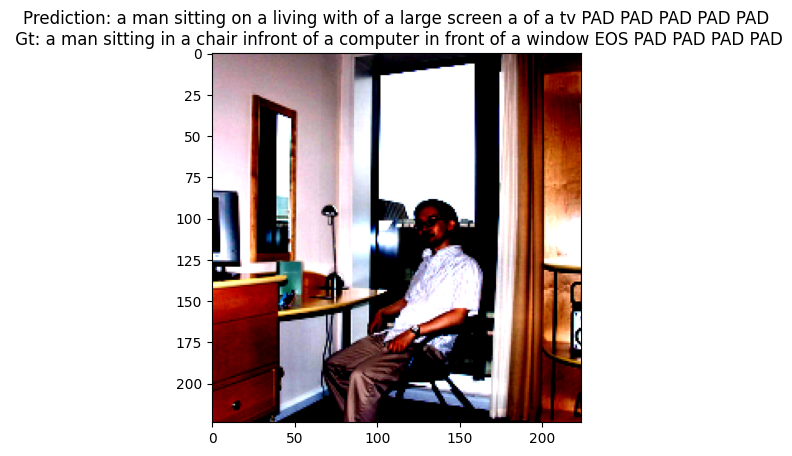

In [25]:
batch_id = 2
Prediction=' '.join([words[ind] for ind in torch.argmax(out[batch_id],dim=-1)])
Gt=' '.join([words[ind] for ind in label[batch_id]])

plt.title('Prediction: '+ Prediction+'\n Gt: '+Gt)
plt.imshow(image[batch_id].permute(1,2,0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


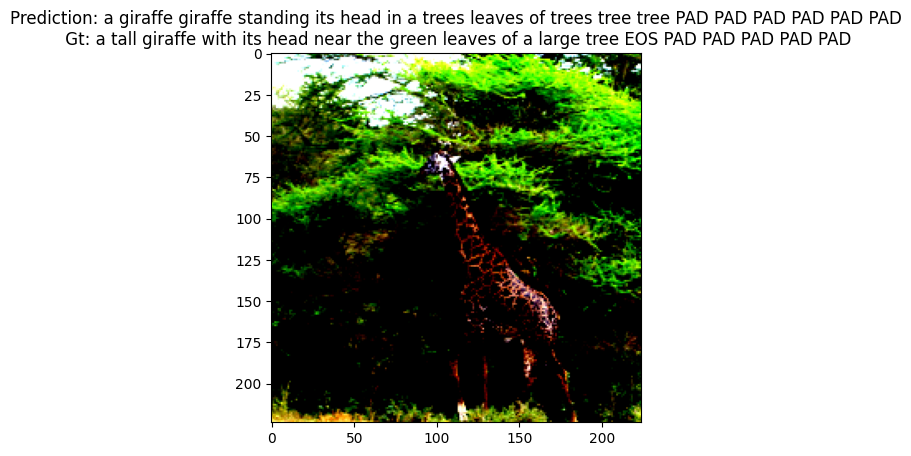

In [28]:
batch_id = 5
Prediction=' '.join([words[ind] for ind in torch.argmax(out[batch_id],dim=-1)])
Gt=' '.join([words[ind] for ind in label[batch_id]])

plt.title('Prediction: '+ Prediction+'\n Gt: '+Gt)
plt.imshow(image[batch_id].permute(1,2,0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


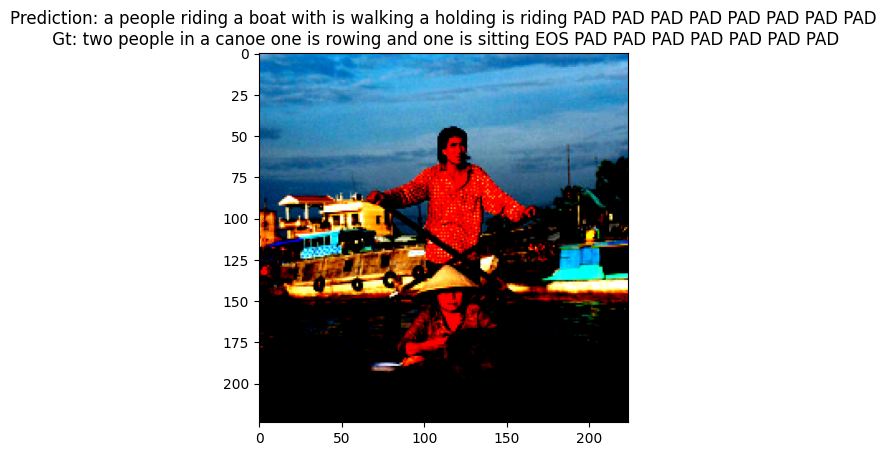

In [29]:
batch_id = 16
Prediction=' '.join([words[ind] for ind in torch.argmax(out[batch_id],dim=-1)])
Gt=' '.join([words[ind] for ind in label[batch_id]])

plt.title('Prediction: '+ Prediction+'\n Gt: '+Gt)
plt.imshow(image[batch_id].permute(1,2,0).cpu())

Проверим на валидационной выборке. Посчитаем top5 acc метрику на 5000 изображений:

In [30]:
val_loader = torch.utils.data.DataLoader(dataset, 1, 
                                           shuffle=True, 
                                           collate_fn=collate_sentences
                                          )

In [31]:
from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
model.eval()
llm_model.eval()

loader = tqdm(enumerate(val_loader))

topks = []
for idx, data in loader:
    image, label, lens, r = data
    image, label = image.to(device), label.to(device)
    with torch.no_grad():
        feature = model.features(image)

    start_symbol = label.new_full((label.size(0),1),word_to_id['BOS'])
    input_label = torch.cat([start_symbol, label],dim=-1)[:,:num_steps]

    out, encoded_captions, decode_lens, alphas = llm_model(feature.permute(0,2,3,1), input_label, lens)
    scores = pack_padded_sequence(
        out, lens, batch_first=True
    )
    targets = pack_padded_sequence(
        label, lens, batch_first=True
    )

    topk = accuracy(scores.data, targets.data, 5)
    topks.append(topk)
    loader.set_description(f"iteration: {idx}")

    if idx>5000:
        break 


iteration: 5001: : 5001it [02:27, 33.88it/s]

Mean TopK: 73.24579878582273


Создадим функцию для генерации собственного текста. Если до этого мы обучали сеть лишь предсказывать следующее слово после n известных, то теперь будем давать на вход BOS и генерировать каждое следующее слово из получающегося контекста. Так мы скорее всего судем получать более складные предложения (так как до этого в обоих лабах при генерации мы лишь предсказывали следующее слово но не учитывали то что сеть уже напридумала, поэтому получался просто набор слов без какой-то возможной грамматической связи -teacher forcing был подход до этого)

In [33]:
def new_describtion(index=1):
    llm_model.eval()

    image_path = f"val2014/{os.listdir('val2014')[index]}"

    vocab_size = len(words)
    downscale_model_factor = 2 ** 5 # stride 2 is happened 5 times
    # id to word mapping
    rev_word_map = {id: word for id, word in enumerate(words)}

    # read and pre-process image
    img = Image.open(image_path).convert('RGB')
    img = transform(img)    # (3, 256, 256)

    # ==========================================
    # Feature extraction. encode the image
    encoder_out = model.features(img.unsqueeze(0).to(device))
    encoder_out = encoder_out.permute(0,2,3,1)     # (1, enc_image_size, enc_image_size, feature_dim)

    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # flatten encoded image representation
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)
    # ==========================================

    # ==========================================
    # LLM init
    prev_words = torch.tensor([[word_to_id['BOS']]], dtype=torch.long).to(device)   # (1, 1)
    seqs = prev_words   # (1, 1)
    scores = torch.zeros(1, 1).to(device)     # (1, 1)
    seqs_alpha = torch.ones(1, 1, enc_image_size, enc_image_size).to(device)  # (1, 1, enc_image_size, enc_image_size)

    # start decoding
    step = 1
    h, c = llm_model.init_hidden_state(encoder_out)
    # ==========================================


    max_steps = 50
    while True:
        # ==========================================
        # Повторяем весь код инференса из llm модели (forward)
        #
        embeddings = llm_model.embed(prev_words).squeeze(1)  # (1, embed_dim)
        attention_weighted_encoding, alpha = llm_model.attention(encoder_out, h)  # (1, encoder_dim), (1, num_pixels, 1)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)     # (1, enc_image_size, enc_image_size)
        gate = F.sigmoid(llm_model.f_beta(h))      # gating scalar, (1, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding
        h, c = llm_model.lstm_cell(
            torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
        )   # (s, decoder_dim)
        scores = llm_model.fc(h)      # (s, vocab_size)
        #
        # ==========================================
        scores = F.log_softmax(scores, dim=1)
        scores = scores.expand_as(scores) + scores    # (1, vocab_size) 
        top_score, top_word = scores.max(dim=1)     # (1)
        next_word_inds = top_word

        # add new words to sequences, alphas
        seqs = torch.cat([seqs, next_word_inds.unsqueeze(0)], dim=1)    # (1, step + 1)
        seqs_alpha = torch.cat(
            [seqs_alpha, alpha.unsqueeze(1)], dim=1
        )   # (1W, step + 1, enc_image_size, enc_image_size)
        if next_word_inds[0] == word_to_id['EOS']:
            break
        # break if things have been going on too long
        if step > max_steps:
            break
        prev_words = next_word_inds
        step += 1
        
    i = 0
    seq = seqs[i].tolist()

    caption = [rev_word_map[ind] for ind in seq]
    
    img = Image.open(image_path).convert('RGB')

    plt.title(f'Prediction: {" ".join(caption)}')
    plt.imshow(img)

Пример генерации при подачи фотки из валидации:

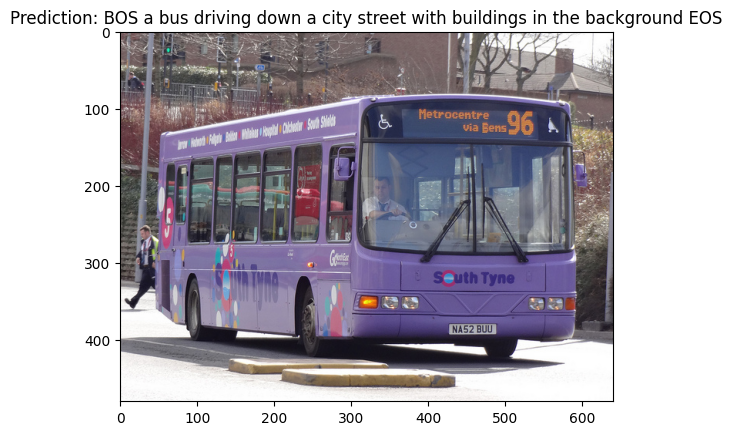

In [34]:
new_describtion(index=156)

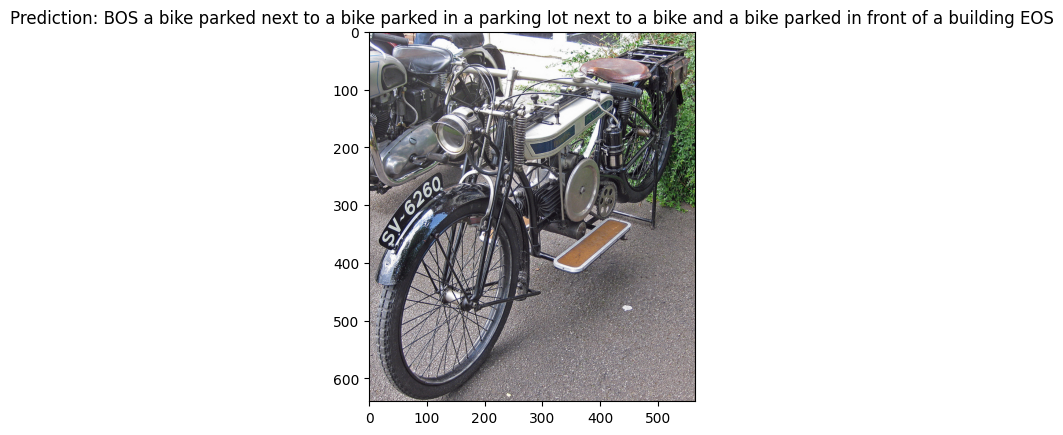

In [35]:
new_describtion(index=1)

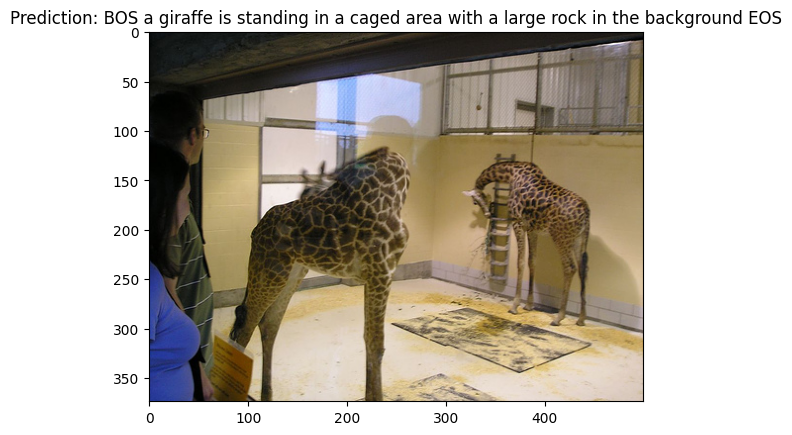

In [36]:
new_describtion(index=4)


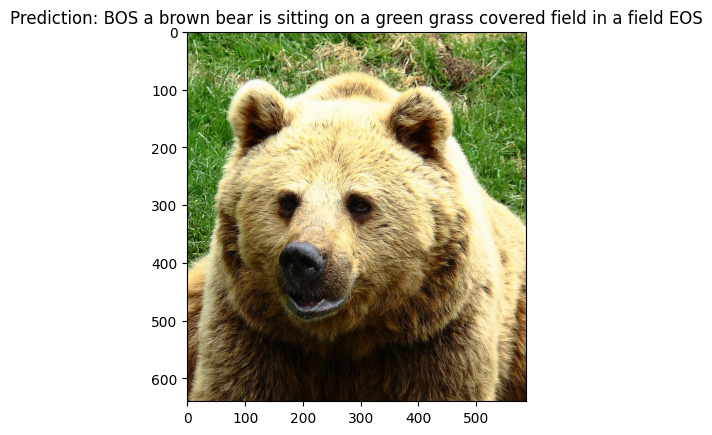

In [40]:
new_describtion(index=14)

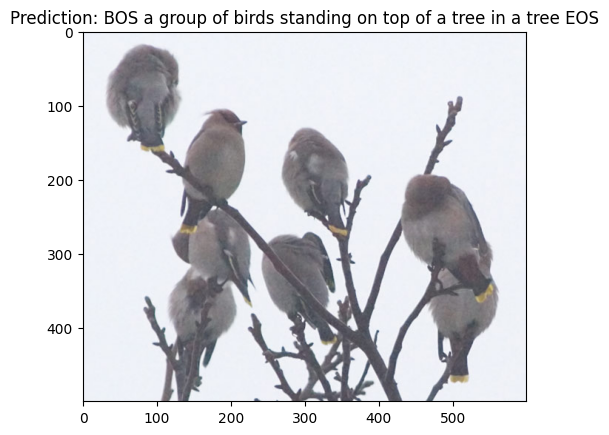

In [41]:
new_describtion(index=6)

В данной ячейке реализована идентичная функция описанной выше но на этот раз мы выводим результаты soft attention на каждой итерации генерации

In [45]:
def att_show(VAL_INDEX):
    llm_model.eval()

    image_path = f"val2014/{os.listdir('val2014')[VAL_INDEX]}"

    vocab_size = len(words)
    downscale_model_factor = 2 ** 5 # stride 2 is happened 5 times
    # id to word mapping
    rev_word_map = {id: word for id, word in enumerate(words)}

    # read and pre-process image
    img = Image.open(image_path).convert('RGB')
    img = transform(img)    # (3, 256, 256)

    # ==========================================
    # Feature extraction. encode the image
    encoder_out = model.features(img.unsqueeze(0).to(device))
    encoder_out = encoder_out.permute(0,2,3,1)     # (1, enc_image_size, enc_image_size, feature_dim)

    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # flatten encoded image representation
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)
    # ==========================================

    # ==========================================
    # LLM init
    prev_words = torch.tensor([[word_to_id['BOS']]], dtype=torch.long).to(device)   # (1, 1)
    seqs = prev_words   # (1, 1)
    scores = torch.zeros(1, 1).to(device)     # (1, 1)
    seqs_alpha = torch.ones(1, 1, enc_image_size, enc_image_size).to(device)  # (1, 1, enc_image_size, enc_image_size)

    # start decoding
    step = 1
    h, c = llm_model.init_hidden_state(encoder_out)
    # ==========================================


    max_steps = 50
    while True:
        # ==========================================
        # Повторяем весь код инференса из llm модели (forward)
        #
        embeddings = llm_model.embed(prev_words).squeeze(1)  # (1, embed_dim)
        attention_weighted_encoding, alpha = llm_model.attention(encoder_out, h)  # (1, encoder_dim), (1, num_pixels, 1)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)     # (1, enc_image_size, enc_image_size)
        gate = F.sigmoid(llm_model.f_beta(h))      # gating scalar, (1, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding
        h, c = llm_model.lstm_cell(
            torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
        )   # (s, decoder_dim)
        scores = llm_model.fc(h)      # (s, vocab_size)
        #
        # ==========================================
        scores = F.log_softmax(scores, dim=1)
        scores = scores.expand_as(scores) + scores    # (1, vocab_size) 
        top_score, top_word = scores.max(dim=1)     # (1)
        next_word_inds = top_word

        # add new words to sequences, alphas
        seqs = torch.cat([seqs, next_word_inds.unsqueeze(0)], dim=1)    # (1, step + 1)
        seqs_alpha = torch.cat(
            [seqs_alpha, alpha.unsqueeze(1)], dim=1
        )   # (1W, step + 1, enc_image_size, enc_image_size)
        if next_word_inds[0] == word_to_id['EOS']:
            break
        # break if things have been going on too long
        if step > max_steps:
            break
        prev_words = next_word_inds
        step += 1

    i = 0
    seq = seqs[i].tolist()
    alphas = seqs_alpha[i].tolist()

    caption = [rev_word_map[ind] for ind in seq]
    print('Что выдает argmax на результат выхода сети: ', seq)
    print('Исходя из словаря переписал результат в список слов:', caption)

    img = Image.open(image_path).convert('RGB')
    img = img.resize([14 * 24, 14 * 24], Image.LANCZOS)

    # plot the image and attention map
    fig = plt.figure(figsize=(20, 8))
    for t in range(len(caption)):

        plt.subplot(int(np.ceil(len(caption) / 5.)), 5, t + 1)
        plt.text(0, 1, '%s' % (caption[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(img)

        current_alpha = np.array(alphas[t])
        alpha = skimage.transform.pyramid_expand(current_alpha, upscale=downscale_model_factor, sigma=8)
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)

        plt.set_cmap('gray')
        plt.axis('off')

    plt.show()

Что выдает argmax на результат выхода сети:  [3, 4, 68, 242, 34, 4, 25, 22, 14, 4, 62, 9, 4, 56, 8, 7, 154, 2]
Исходя из словаря переписал результат в список слов: ['BOS', 'a', 'bus', 'driving', 'down', 'a', 'street', 'next', 'to', 'a', 'building', 'with', 'a', 'sign', 'in', 'the', 'background', 'EOS']


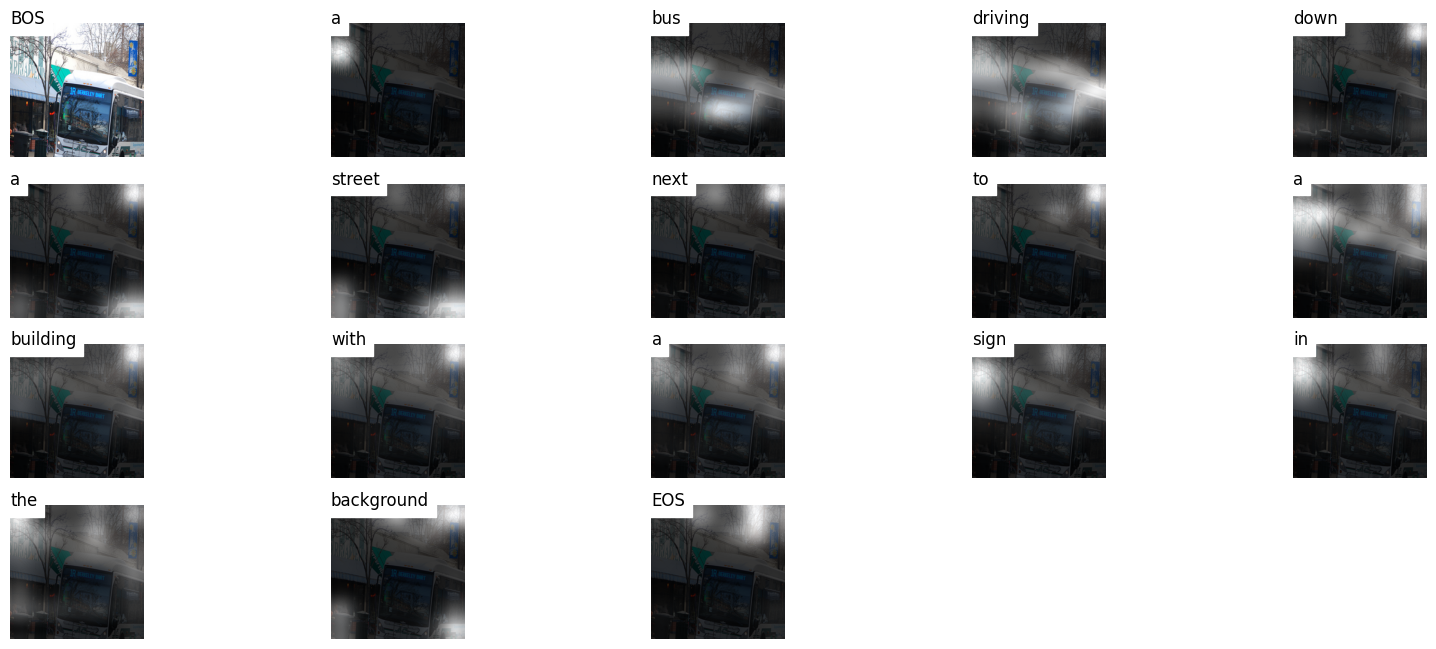

In [55]:
att_show(45)

Что выдает argmax на результат выхода сети:  [3, 4, 13, 8, 4, 61, 185, 11, 55, 38, 5, 4, 149, 9, 4, 206, 8, 7, 154, 2]
Исходя из словаря переписал результат в список слов: ['BOS', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'playing', 'tennis', 'on', 'a', 'court', 'with', 'a', 'racket', 'in', 'the', 'background', 'EOS']


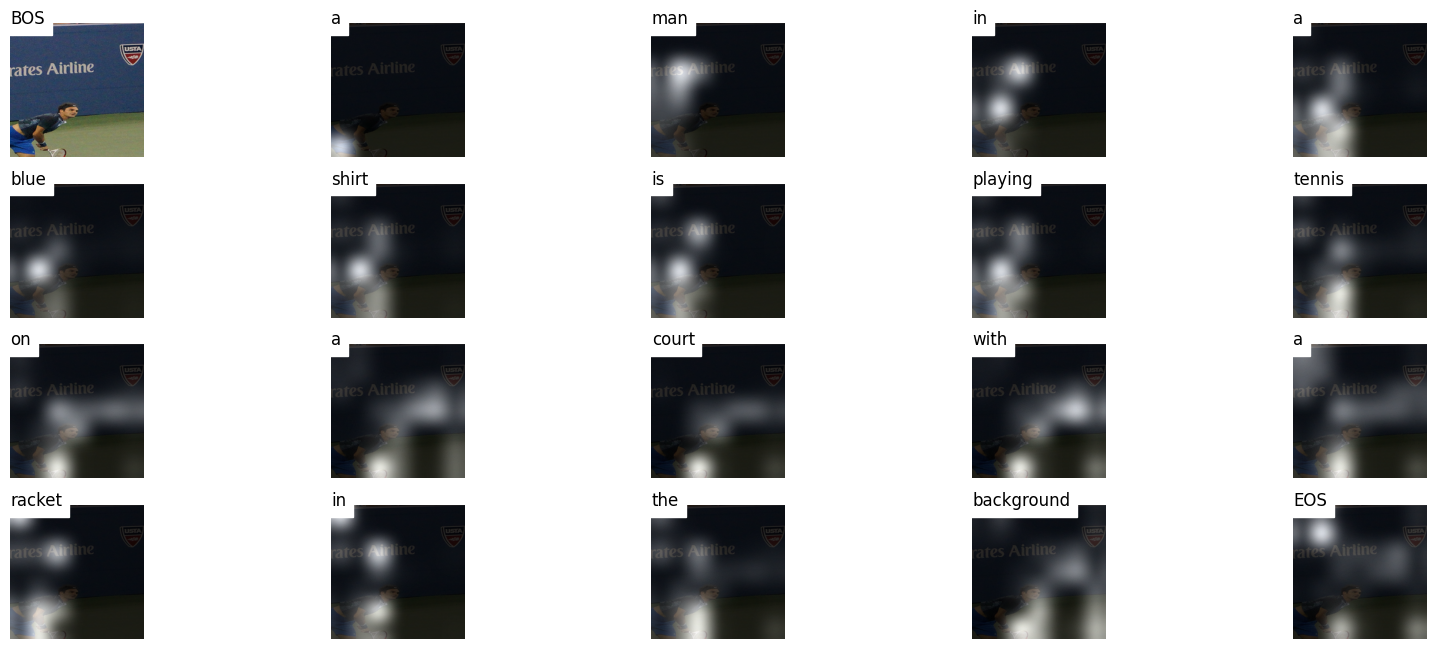

In [53]:
att_show(25)

Что выдает argmax на результат выхода сети:  [3, 4, 58, 93, 27, 4, 188, 5, 4, 37, 9, 4, 58, 188, 8, 7, 154, 2]
Исходя из словаря переписал результат в список слов: ['BOS', 'a', 'baseball', 'player', 'holding', 'a', 'bat', 'on', 'a', 'field', 'with', 'a', 'baseball', 'bat', 'in', 'the', 'background', 'EOS']


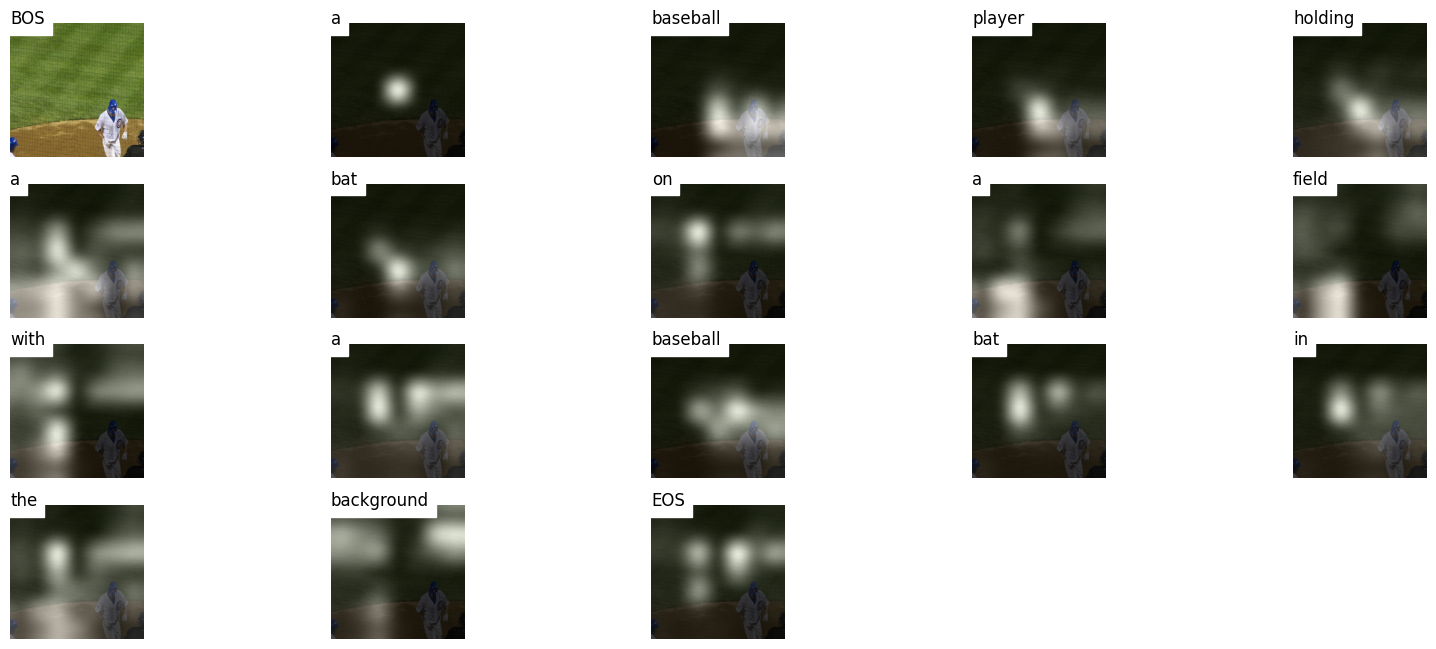

In [52]:
att_show(8)

### __Выводы__<br>
Благодаря реализации Attention механизма в процессе генерации описания, на каждом новом этапе выбора слова сеть заново смотрела на изображение (на взвешенное с помошью soft attention) и тем самым была более точна в выборе слов. Благорадя этому подходу мы так же смогли добиться получения оконченных предложений без бесконечного зацикливания как было в прошлой модели. Так же мы получили очень высокое значение acc Top5 на валидации.

## Ссылки 

[1]Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.

[2]Xu, Kelvin, et al. "Show, attend and tell: Neural image caption generation with visual attention." International conference on machine learning. PMLR, 2015.

[3]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.